# Project description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

In [1]:
# Data calculation and analysis libraries
import pandas as pd
import numpy as np
import math as m
import sidetable as stb
import datetime as dt

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Split & shuffle function
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Data engineering libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Evaluation metrics 
from sklearn.metrics import roc_auc_score, f1_score

# A hyperparameter optimization framework to automate hyperparameter search
import optuna

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Time and constant
import time
last_date = dt.datetime(2020,2,1)
randomness = 42

# notbook 
pd.options.display.max_columns = None
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
contract_data = pd.read_csv('contract.csv',
                           parse_dates=['BeginDate'])

contract_data.columns = ['cid','start_date','end_date','contract_type','paperless_billing',
                         'payment_method','monthly_charges','total_charges']

contract_data['active_user'] = contract_data.end_date.map(lambda i: 1 if i == 'No' else 0).astype('uint8')
contract_data['end_date'] = contract_data.end_date.map(lambda i: float('NaN') if i == 'No' else i).astype('datetime64[D]')
contract_data['paperless_billing'] = contract_data.paperless_billing.eq('Yes').mul(1).astype('uint8')
contract_data['total_charges'] = contract_data.total_charges.map(lambda i: 0 if i == ' ' else i).astype('float')
contract_data['contract_duration'] = (contract_data.end_date.fillna(last_date) - contract_data.start_date)/ np.timedelta64(1,'D')

print(contract_data.head())
contract_data.info()

          cid start_date   end_date   contract_type  paperless_billing  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month                  1   
1  5575-GNVDE 2017-04-01        NaT        One year                  0   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                  1   
3  7795-CFOCW 2016-05-01        NaT        One year                  0   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                  1   

              payment_method  monthly_charges  total_charges  active_user  \
0           Electronic check            29.85          29.85            1   
1               Mailed check            56.95        1889.50            1   
2               Mailed check            53.85         108.15            0   
3  Bank transfer (automatic)            42.30        1840.75            1   
4           Electronic check            70.70         151.65            0   

   contract_duration  
0               31.0  
1             1036.0  
2               61.0  


In [3]:
personal_data = pd.read_csv('personal.csv')

personal_data.columns = ['cid','gender','senior_citizen','partner','dependents']
personal_data['gender'] = personal_data.gender.map(lambda i: 1 if i == 'Male' else 0)
personal_data['partner'] = personal_data.partner.map(lambda i: 1 if i == 'Yes' else 0) 
personal_data['dependents'] = personal_data.dependents.map(lambda i: 1 if i == 'Yes' else 0) 

print(personal_data.head())
personal_data.info()

          cid  gender  senior_citizen  partner  dependents
0  7590-VHVEG       0               0        1           0
1  5575-GNVDE       1               0        0           0
2  3668-QPYBK       1               0        0           0
3  7795-CFOCW       1               0        0           0
4  9237-HQITU       0               0        0           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cid             7043 non-null   object
 1   gender          7043 non-null   int64 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


In [4]:
internet_data = pd.read_csv('internet.csv')

internet_data.columns = ['cid','internet_service','online_security','online_backup','device_protection', 
                         'tech_support','streaming_tv','streaming_movies']

colist = ['online_security','online_backup','device_protection', 'tech_support','streaming_tv','streaming_movies']

for col in colist:
    internet_data[col] = internet_data[col].map(lambda i: 1 if i == 'Yes' else 0)

print(internet_data.head())
internet_data.info()

          cid internet_service  online_security  online_backup  \
0  7590-VHVEG              DSL                0              1   
1  5575-GNVDE              DSL                1              0   
2  3668-QPYBK              DSL                1              1   
3  7795-CFOCW              DSL                1              0   
4  9237-HQITU      Fiber optic                0              0   

   device_protection  tech_support  streaming_tv  streaming_movies  
0                  0             0             0                 0  
1                  1             0             0                 0  
2                  0             0             0                 0  
3                  1             1             0                 0  
4                  0             0             0                 0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             ------------

In [5]:
phone_data = pd.read_csv('phone.csv')

phone_data.columns = ['cid','multiple_lines']
phone_data['multiple_lines'] = phone_data.multiple_lines.map(lambda i: 1 if i == 'Yes' else 0) 

print(phone_data.head())
phone_data.info()

          cid  multiple_lines
0  5575-GNVDE               0
1  3668-QPYBK               0
2  9237-HQITU               0
3  9305-CDSKC               1
4  1452-KIOVK               1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cid             6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [6]:
merged_data = contract_data.copy()
merged_data = merged_data.merge(personal_data, on='cid',how='left')
merged_data = merged_data.merge(internet_data, on='cid',how='left')
merged_data = merged_data.merge(phone_data, on='cid',how='left')

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cid                7043 non-null   object        
 1   start_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   contract_type      7043 non-null   object        
 4   paperless_billing  7043 non-null   uint8         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active_user        7043 non-null   uint8         
 9   contract_duration  7043 non-null   float64       
 10  gender             7043 non-null   int64         
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   int64         
 13  dependents         7043 non-null   int64         
 14  internet

### Plan for solving the task:
- Exploratory Data Analysis
- Feature engineering (address class imbalance)
- train/test/(validation) split
- Hyperparameter tuning and finding the best model on the validation set
- Testing your final model on the test set

### EDA:

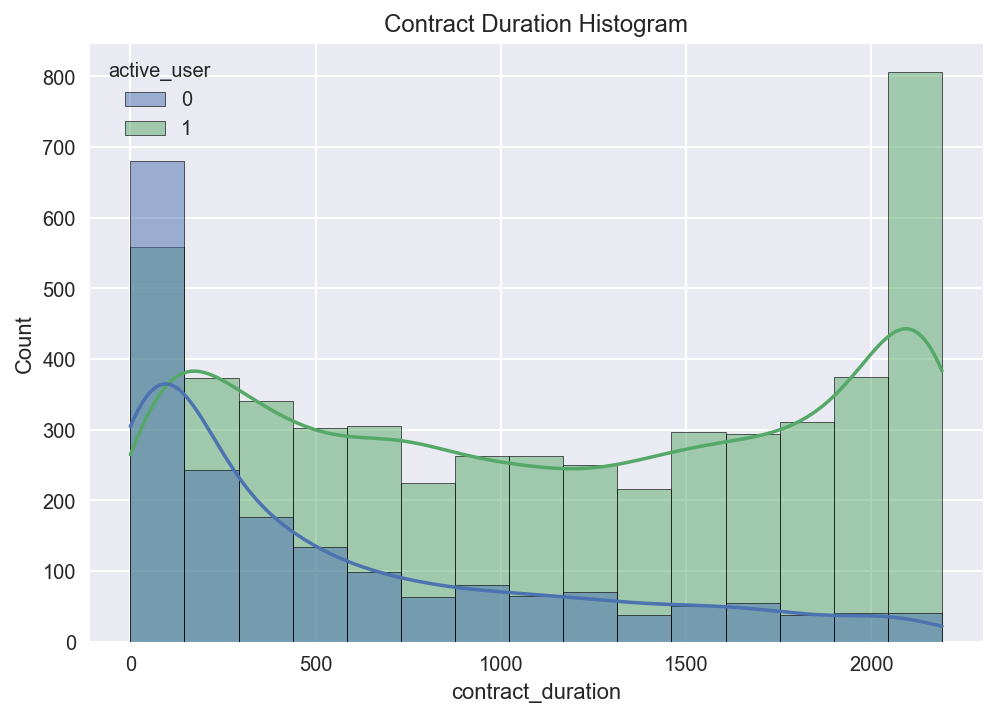

In [7]:
sns.histplot(data=contract_data, 
             x="contract_duration", 
             hue="active_user", 
             kde=True).set(title='Contract Duration Histogram');

In [8]:
print(merged_data.active_user.value_counts(),'\n')
print(merged_data.query('contract_duration > 1000').active_user.value_counts())

1    5174
0    1869
Name: active_user, dtype: int64 

1    2859
0     409
Name: active_user, dtype: int64


In [9]:
def ohe_fast(data, col):
    if data[col].isna().sum() > 0:
        data = pd.concat([data,pd.get_dummies(data[col], prefix= col ,dummy_na=True,drop_first=True)],axis=1)
    else:
        data = pd.concat([data,pd.get_dummies(data[col], prefix= col ,drop_first=True)],axis=1)
        
    data.drop(col,axis=1, inplace=True)
    return data

In [10]:
data_ohe = merged_data.copy()
data_ohe.drop(['cid','end_date', 'start_date'], axis=1, inplace=True)
data_ohe['internet_service'] = data_ohe['internet_service'].fillna('No')
data_ohe = data_ohe.fillna(0)

num_col = ['monthly_charges', 'total_charges', 'contract_duration']
ordinal_col = ['contract_type', 'payment_method', 'internet_service']
cat_col = list(set(data_ohe.columns) - set(num_col) - set(ordinal_col))

for col in cat_col:
    data_ohe[col] = data_ohe[col].astype('uint8')

for col in ordinal_col:
    data_ohe = ohe_fast(data_ohe, col)

In [11]:
train, test = train_test_split(data_ohe, test_size = 0.2, random_state = randomness, shuffle = True)

scaler = MinMaxScaler(copy = False)
train[num_col] = scaler.fit_transform(train[num_col])
test[num_col] = scaler.transform(test[num_col])

In [12]:
features_train = train.drop(['active_user'], axis=1)
target_train = train['active_user']

features_test = test.drop(['active_user'], axis=1)
target_test = test['active_user']

features_train.shape , target_train.shape , features_test.shape , target_test.shape

((5634, 22), (5634,), (1409, 22), (1409,))

In [13]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 2142 to 860
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       5634 non-null   uint8  
 1   monthly_charges                         5634 non-null   float64
 2   total_charges                           5634 non-null   float64
 3   contract_duration                       5634 non-null   float64
 4   gender                                  5634 non-null   uint8  
 5   senior_citizen                          5634 non-null   uint8  
 6   partner                                 5634 non-null   uint8  
 7   dependents                              5634 non-null   uint8  
 8   online_security                         5634 non-null   uint8  
 9   online_backup                           5634 non-null   uint8  
 10  device_protection                       5634 non-null   ui

### Upsample:

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sklearn.metrics as metrics

In [15]:
%%time
from sklearn.tree import DecisionTreeClassifier
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]
for k in k_values:
# define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.7, k_neighbors=k, random_state = randomness)
    under = RandomUnderSampler( random_state = randomness)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, features_train, target_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = scores.mean()
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.704
> k=2, Mean ROC AUC: 0.702
> k=3, Mean ROC AUC: 0.709
> k=4, Mean ROC AUC: 0.706
> k=5, Mean ROC AUC: 0.710
> k=6, Mean ROC AUC: 0.709
> k=7, Mean ROC AUC: 0.704
> k=8, Mean ROC AUC: 0.706
> k=9, Mean ROC AUC: 0.708
> k=10, Mean ROC AUC: 0.708
CPU times: total: 1.28 s
Wall time: 10.3 s


In [23]:
best_k = 5

In [24]:
over = SMOTE(sampling_strategy=0.7, k_neighbors=best_k, random_state = randomness)
under = RandomUnderSampler( random_state = randomness)

print("Original:          ",features_train.shape)
X_res, y_res = over.fit_resample(features_train, target_train)
print("SMOTE:             ",X_res.shape)
X_res, y_res = under.fit_resample(X_res, y_res)
print("RandomUnderSampler:",X_res.shape)

Original:           (5634, 22)
SMOTE:              (7034, 22)
RandomUnderSampler: (5792, 22)


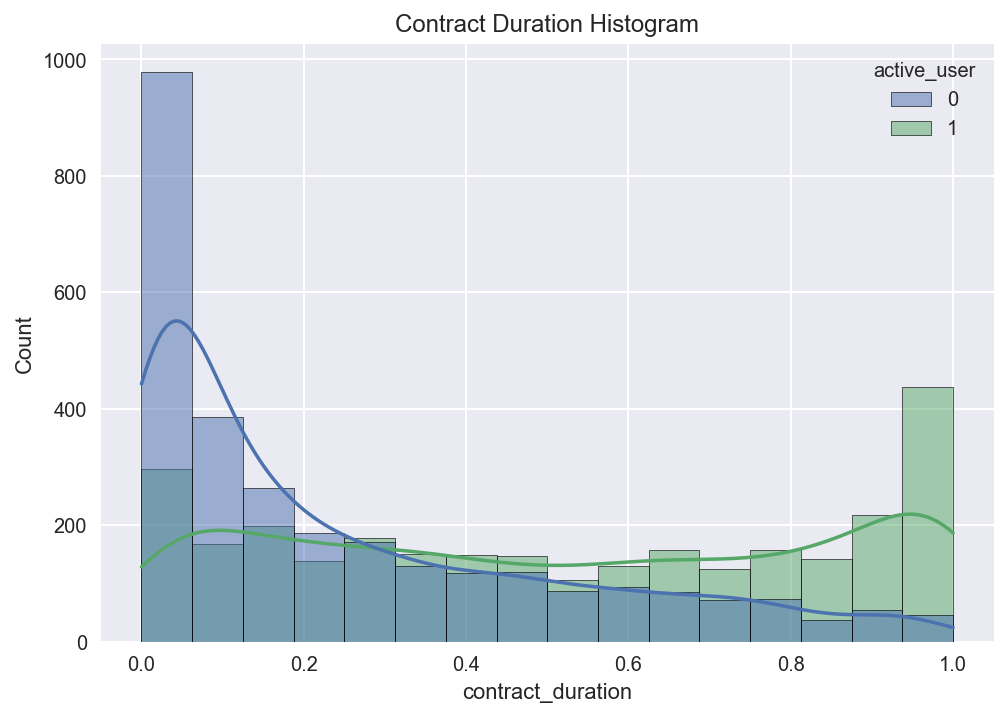

In [29]:
plot_df = pd.concat([X_res, y_res], axis=1, join='inner')

sns.histplot(data=plot_df, 
             x="contract_duration", 
             hue="active_user", 
             kde=True).set(title='Resampled Contract Duration Histogram');

### Model Comparison:

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [34]:
def model_evaluation( model, features_train, target_train):
    
    t0= time.time()
    
    # define pipeline
    over = SMOTE(sampling_strategy=0.7, k_neighbors=best_k, random_state = randomness)
    under = RandomUnderSampler( random_state = randomness)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=randomness)
    scores = cross_val_score(pipeline, features_train, target_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    t1= time.time()

    score= {'model': [str(model).split('(', 1)[0]],
            'cv_mean': [scores.mean()],
            'cv_min': [scores.min()],
            'cv_max': [scores.max()],
            'cv_std': [scores.std()],
            'time': [t1 - t0],
           }  

    return pd.DataFrame(score)

In [35]:
def test_model( model, features_train, target_train, features_test, target_test):
    
    t0= time.time()
    model.fit(features_train, target_train)
    predictions1 = model.predict_proba(features_train)[:, 1]
    predictions2 = model.predict_proba(features_test)[:, 1]
    
    predict1 = model.predict(features_train)
    predict2 = model.predict(features_test)
    t1= time.time()

    score= {'model': [str(model).split('(', 1)[0]],
            'train_acc': [metrics.accuracy_score(target_train, predict1)],
            'train_roc_auc': [metrics.roc_auc_score(target_train, predictions1)],
            'test_acc': [metrics.accuracy_score(target_test, predict2)],
            'test_roc_auc': [metrics.roc_auc_score(target_test, predictions2)],
            'time': [t1 - t0],
           }  

    return pd.DataFrame(score)

In [36]:
%%time
model_score_ev =  pd.DataFrame()

list_of_models = [LogisticRegression(random_state = randomness),
                  SVC(random_state = randomness),
                  GaussianNB(), 
                  MultinomialNB(),
                  SGDClassifier(random_state = randomness),
                  KNeighborsClassifier(),
                  DecisionTreeClassifier(random_state = randomness),
                  RandomForestClassifier(random_state = randomness),
                  GradientBoostingClassifier(random_state = randomness),
                  CatBoostClassifier(random_state = randomness, silent = True)
                 ]

for mod in list_of_models:
    model_score_ev = model_score_ev.append(model_evaluation( mod, features_train, target_train))

model_score_ev.sort_values(by = "cv_mean", ascending=False)

CPU times: total: 844 ms
Wall time: 32.3 s


,model,cv_mean,cv_min,cv_max,cv_std,time
0,<catboost.core.CatBoostClassifier object at 0x...,0.883539,0.854250,0.905214,0.012303,22.538948
0,GradientBoostingClassifier,0.870563,0.847646,0.890712,0.011861,2.154994
0,LogisticRegression,0.833310,0.810174,0.852503,0.010070,0.369000
0,RandomForestClassifier,0.832907,0.806616,0.857839,0.013342,1.853993
0,SGDClassifier,0.826107,0.799075,0.849264,0.011127,0.268001
0,GaussianNB,0.825421,0.802706,0.836988,0.008596,0.194058
0,MultinomialNB,0.822174,0.800925,0.835979,0.008445,0.183999
0,SVC,0.813830,0.790669,0.838405,0.012011,4.053960
0,KNeighborsClassifier,0.771705,0.748905,0.797950,0.012448,0.262999
0,DecisionTreeClassifier,0.709011,0.684581,0.728237,0.011818,0.234994


- I will preform hyperparameter tuning on CatBoostClassifier

### Hyperparameter tuning:

In [37]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_test ={
             'iterations': [ 1000, 1200, 1400, 1600 ],
             'learning_rate':[0.03, 0.05, 0.08, 0.1]
            }

clf = CatBoostClassifier(random_state = randomness,
                         l2_leaf_reg = 1,
                         eval_metric = 'AUC',
                         early_stopping_rounds = 5,
                         custom_loss = 'AUC',
                         depth = 6,
                         silent = True )

rf_random = RandomizedSearchCV(estimator=clf, 
                               param_distributions = param_test, 
                               n_iter= 100,
                               scoring='roc_auc',
                               cv=5,
                               refit=True,
                               random_state=randomness,
                               verbose=2,
                               n_jobs = -1)

rf_random.fit(X_res, y_res, early_stopping_rounds=500)
print('Best Hyperparameters:',rf_random.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'learning_rate': 0.1, 'iterations': 1000}
CPU times: total: 25.3 s
Wall time: 2min 59s


### Compare model to baseline ( Zero Rate Classifier ):

In [59]:
def baceline(target_train, target_test):
    
    t0= time.time()
    value = np.bincount(target_test).argmax()
    predictions1 = [value] * len(target_train)
    predictions2 = [value] * len(target_test)
    t1= time.time()

    score= {'model': "Zero Rate Classifier",
            'train_acc': [metrics.accuracy_score(target_train, predictions1)],
            'train_roc_auc': [metrics.roc_auc_score(target_train, predictions1)],
            'test_acc': [metrics.accuracy_score(target_test, predictions2)],
            'test_roc_auc': [metrics.roc_auc_score(target_test, predictions2)],
            'time': [t1 - t0],
           }  

    return pd.DataFrame(score)

In [56]:
mod = CatBoostClassifier(random_state = randomness,
                         iterations =  1000,
                         l2_leaf_reg = 1,
                         eval_metric = 'AUC',
                         learning_rate = 0.1,
                         early_stopping_rounds = 5,
                         custom_loss = 'AUC',
                         subsample = 0.9,
                         depth = 6,
                         silent = True,
                        )

In [60]:
baceline( y_res,target_test)

,model,train_acc,train_roc_auc,test_acc,test_roc_auc,time
0,Zero Rate Classifier,0.5,0.5,0.735273,0.5,0.0


In [61]:
test_model(mod,X_res, y_res,features_test,target_test)

,model,train_acc,train_roc_auc,test_acc,test_roc_auc,time
0,<catboost.core.CatBoostClassifier object at 0x...,0.99741,0.999866,0.877928,0.932964,3.248784


### Conclusions:
- I got test 'roc_auc' of 0.93 using "CatBoostClassifier".